This notebook was written on colab but doesn't require CUDA and CUDNN. This notebook performs object detection on a video using a trained YOLO model. It used openCV.

## Variables to be modified 

In [ ]:
# The .txt file containing the class name
Class_file = '/content/drive/MyDrive/Computer_Vision/Yolo_builds/Colour_Helmet_detection/class_names.txt'

# Pre-trained YOLO weight file
Weight_file = '/content/drive/MyDrive/Computer_Vision/Yolo_builds/Colour_Helmet_detection/Weights_save/yolov3-voc_27200.weights' #Path to weight file

# Yolo .conf file
Conf_file = '/content/drive/MyDrive/Computer_Vision/Yolo_builds/Colour_Helmet_detection/yolov3-voc.cfg' #Path to conf file

# The test video
Test_file = '/content/drive/MyDrive/Computer_Vision/Yolo_builds/Helmet_detection/Test_videos/Test_video_cust.mp4' #Source file

# The detected video
Detected_file = '/content/drive/MyDrive/Computer_Vision/Yolo_builds/Colour_Helmet_detection/Detected_videos/Test_video_Tracking.avi' #Destination file

## Installations, Importations

In [ ]:
#!pip install GitPython
#Repo.clone_from("https://github.com/pjreddie/darknet", "/sample_data/darknet")

import cv2 as cv 
import numpy as np
from matplotlib import pyplot as plt
import os
import imutils
from google.colab.patches import cv2_imshow  
import time
from IPython. display import clear_output
import sys
%matplotlib inline

## Mounting drive

In [ ]:
# MOUNT DRIVE - (Mounted drive can be accessed at /content/drive/MyDrive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get the classes

In [ ]:
# read class names from text file
classes = None
with open(Class_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['Blue', 'Yellow', 'White', 'Red', 'None']


## Build model and set parameters

In [ ]:
net = cv.dnn.readNet(Weight_file, Conf_file)

# The image parameters to be considered for all images in the observed data
Width = 864
Height = 480
scale = 1/255

# Bounding box prediction Thresholds
conf_threshold = 0.6
nms_threshold = 0.3

## Read video and try to find the number of frames in the video

In [ ]:
# initialize the video stream, pointer to output video file, and frame dimensions

stride = 4 #output stride

vs = cv.VideoCapture(Test_file)
writer = None
(W, H) = (None, None)

# try to determine the total number of frames in the video file
try:
	prop = cv.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() else cv.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# an error occurred while trying to determine the total number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	total = -1

# try to determine the FPS of the video file
try:
	prop = cv.cv.CV_CAP_PROP_FPS if imutils.is_cv2() else cv.CAP_PROP_FPS
	Fps = int(vs.get(prop))
	print("[INFO] {} is the FPS of video".format(Fps))

# an error occurred while trying to determine the total number of frames in the video file
except:
	print("[INFO] could not determine FPS of video")
	total = -1

[INFO] 14638 total frames in video
[INFO] 30 is the FPS of video


## Some functions 

In [ ]:
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])+', '+str(round(confidence, 3))
    COLORS = np.array([[254.9,0.1,0.1],[0.1,254.9,254.9],[254.9,254.9,254.9],[0.1,0.1,254.9],[0.1,254.9,0.1]])
    #COLORS = np.array([[254.9,0.1,0.1],[0.1,0.1,254.9],[0.1,254.9,0.1]])
    color = COLORS[class_id]
    cv.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    #cv.putText(img, label, (x-10,y-10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

## Split the video frame by frame into images. Then pass the images individually through the network

In [ ]:
# loop over frames from the video file stream
vs =  cv.VideoCapture(Test_file)
frame_no = 0
while True:
    # read the next frame from the file   
    (grabbed, FRAME) = vs.read()
    # if the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break
    # if the frame dimensions are empty, grab them(Just get the dimensions of any one frame)
    if W is None or H is None:
        (H, W) = FRAME.shape[:2]

    #Reshape frame to make sure that W, H are divisible by 32. Then new W, H will be used throughout
    FRAME = cv.resize(FRAME, (Width, Height))

    frame_no = frame_no + 1

    #if((frame_no % 200 == 0) && ((frame > 800) && (frame<2400)) || ((frame > 800) && (frame<2400)) || ((frame > 800) && (frame<2400))):
    if((frame_no % stride) != 0):
        continue

    start = time.time()
    # create input blob 
    blob = cv.dnn.blobFromImage(FRAME, scale, (Width, Height), (0,0,0), True, crop=False)

    # set input blob for the network
    net.setInput(blob)

    # forward pass
    outs = net.forward(get_output_layers(net))
    end = time.time()

    clear_output(wait = True)
    print(frame_no, (end-start))#"[INFO] estimated total time to finish: {:.4f}".format(elap * (1500-frame_no)))

    class_ids = [] #Stores the passing bounding box class-id
    confidences = [] #Stores the passing bounding box confidence
    boxes = [] #Stores the passing bounding box [x, y, w, h]

    # For each Scale output in each image output
    for Scale_prediction in outs:

        # No of detection box predictions = (number of anchor boxes per scale)*(width/32)*(height/32)*(scale number)^2
        # For each detection box prediction take up or ignore the bounding box based on confidence value
        for detection in Scale_prediction:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:          
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
        
    # Apply non-max suppression
    indices = cv.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # Go through the detections remaining after nms and draw bounding box
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_bounding_box(FRAME, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv.VideoWriter_fourcc(*"MJPG")
        writer = cv.VideoWriter(Detected_file, fourcc, 30, (FRAME.shape[1], FRAME.shape[0]), True)
		# some information on processing single frame
    if total > 0:
        elap = (end - start)
#        print("[INFO] single frame took {:.4f} seconds".format(elap))
    # write the output frame to disk
    for i in range(stride):
        writer.write(FRAME)

14636 4.885685682296753


# Object tracking - Bytetracker - Not yet finished

## Clone repository and install requirements 

In [ ]:
%cd /content
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack
!pip3 install -r requirements.txt

!pip3 install cython
!pip3 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip3 install cython_bbox

/content
Cloning into 'ByteTrack'...
remote: Enumerating objects: 2000, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 2000 (delta 9), reused 12 (delta 1), pack-reused 1970
Receiving objects: 100% (2000/2000), 79.63 MiB | 35.13 MiB/s, done.
Resolving deltas: 100% (1118/1118), done.
/content/ByteTrack
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Replace Class BYTETracker in yolox/tracker/byte_tracker with the following



---

```
class BYTETracker(object):
    def __init__(self, frame_rate=30):
        self.track_thresh = 0.3 #default 0.6
        self.track_buffer = 30
        self.match_thresh = 0.9
        self.mot20 = False

        self.tracked_stracks = []  # type: list[STrack]
        self.lost_stracks = []  # type: list[STrack]
        self.removed_stracks = []  # type: list[STrack]

        self.frame_id = 0
        #self.det_thresh = args.track_thresh
        self.det_thresh = self.track_thresh + 0.1
        self.buffer_size = int(frame_rate / 30.0 * self.track_buffer)
        self.max_time_lost = self.buffer_size
        self.kalman_filter = KalmanFilter()

    def update(self, output_results, img_info, img_size):
        self.frame_id += 1
        activated_starcks = []
        refind_stracks = []
        lost_stracks = []
        removed_stracks = []

        if output_results.shape[1] == 5:
            scores = output_results[:, 4]
            bboxes = output_results[:, :4]
        else:
            output_results = output_results.cpu().numpy()
            scores = output_results[:, 4] * output_results[:, 5]
            bboxes = output_results[:, :4]  # x1y1x2y2
        img_h, img_w = img_info[0], img_info[1]
        scale = min(img_size[0] / float(img_h), img_size[1] / float(img_w))
        bboxes /= scale

        remain_inds = scores > self.track_thresh
        inds_low = scores > 0.1
        inds_high = scores < self.track_thresh

        inds_second = np.logical_and(inds_low, inds_high)
        dets_second = bboxes[inds_second]
        dets = bboxes[remain_inds]
        scores_keep = scores[remain_inds]
        scores_second = scores[inds_second]

        if len(dets) > 0:
            '''Detections'''
            detections = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                          (tlbr, s) in zip(dets, scores_keep)]
        else:
            detections = []

        ''' Add newly detected tracklets to tracked_stracks'''
        unconfirmed = []
        tracked_stracks = []  # type: list[STrack]
        for track in self.tracked_stracks:
            if not track.is_activated:
                unconfirmed.append(track)
            else:
                tracked_stracks.append(track)

        ''' Step 2: First association, with high score detection boxes'''
        strack_pool = joint_stracks(tracked_stracks, self.lost_stracks)
        # Predict the current location with KF
        STrack.multi_predict(strack_pool)
        dists = matching.iou_distance(strack_pool, detections)
        if not self.mot20:
            dists = matching.fuse_score(dists, detections)
        matches, u_track, u_detection = matching.linear_assignment(dists, thresh=self.match_thresh)

        for itracked, idet in matches:
            track = strack_pool[itracked]
            det = detections[idet]
            if track.state == TrackState.Tracked:
                track.update(detections[idet], self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        ''' Step 3: Second association, with low score detection boxes'''
        # association the untrack to the low score detections
        if len(dets_second) > 0:
            '''Detections'''
            detections_second = [STrack(STrack.tlbr_to_tlwh(tlbr), s) for
                          (tlbr, s) in zip(dets_second, scores_second)]
        else:
            detections_second = []
        r_tracked_stracks = [strack_pool[i] for i in u_track if strack_pool[i].state == TrackState.Tracked]
        dists = matching.iou_distance(r_tracked_stracks, detections_second)
        matches, u_track, u_detection_second = matching.linear_assignment(dists, thresh=0.5)
        for itracked, idet in matches:
            track = r_tracked_stracks[itracked]
            det = detections_second[idet]
            if track.state == TrackState.Tracked:
                track.update(det, self.frame_id)
                activated_starcks.append(track)
            else:
                track.re_activate(det, self.frame_id, new_id=False)
                refind_stracks.append(track)

        for it in u_track:
            track = r_tracked_stracks[it]
            if not track.state == TrackState.Lost:
                track.mark_lost()
                lost_stracks.append(track)

        '''Deal with unconfirmed tracks, usually tracks with only one beginning frame'''
        detections = [detections[i] for i in u_detection]
        dists = matching.iou_distance(unconfirmed, detections)
        if not self.mot20:
            dists = matching.fuse_score(dists, detections)
        matches, u_unconfirmed, u_detection = matching.linear_assignment(dists, thresh=0.7)
        for itracked, idet in matches:
            unconfirmed[itracked].update(detections[idet], self.frame_id)
            activated_starcks.append(unconfirmed[itracked])
        for it in u_unconfirmed:
            track = unconfirmed[it]
            track.mark_removed()
            removed_stracks.append(track)

        """ Step 4: Init new stracks"""
        for inew in u_detection:
            track = detections[inew]
            if track.score < self.det_thresh:
                continue
            track.activate(self.kalman_filter, self.frame_id)
            activated_starcks.append(track)
        """ Step 5: Update state"""
        for track in self.lost_stracks:
            if self.frame_id - track.end_frame > self.max_time_lost:
                track.mark_removed()
                removed_stracks.append(track)

        # print('Ramained match {} s'.format(t4-t3))

        self.tracked_stracks = [t for t in self.tracked_stracks if t.state == TrackState.Tracked]
        self.tracked_stracks = joint_stracks(self.tracked_stracks, activated_starcks)
        self.tracked_stracks = joint_stracks(self.tracked_stracks, refind_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.tracked_stracks)
        self.lost_stracks.extend(lost_stracks)
        self.lost_stracks = sub_stracks(self.lost_stracks, self.removed_stracks)
        self.removed_stracks.extend(removed_stracks)
        self.tracked_stracks, self.lost_stracks = remove_duplicate_stracks(self.tracked_stracks, self.lost_stracks)
        # get scores of lost tracks
        output_stracks = [track for track in self.tracked_stracks if track.is_activated]

        return output_stracks
```



## Develop ByteTrack 

In [ ]:
%cd /content/ByteTrack
!python3 setup.py develop

/content/ByteTrack
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running develop
running egg_info
creating yolox.egg-info
writing yolox.egg-info/PKG-INFO
writing dependency_links to yolox.egg-info/dependency_links.txt
writing top-level names to yolox.egg-info/top_level.txt
writing manifest file 'yolox.egg-info/SOURCES.txt'
package init file 'exps/__init__.py' not found (or not a regular file)
package init file 'tutorials/__init__.py' not found (or not a regular file)
package init file 'tools/__init__.py' not found (or not a regular file)
package init file 'deploy/__init__.py' not found (or not a regular file)
package init file 'assets/__init__.py' not found (or not a regular file)
package init file 'videos/__init__.py' not found (or not a regular file)
package init file 'datasets/__init__.py' not found (or not a regular file)
package init file 'exps/default/__init__.py' not found (or not a regular file)
package init file 'exps/example/__init__.py' not found (or not a regu

## Detection(Yolo model using openCV) + Tracking (using BYTETracker)

[OT_71_(1-1)]
[OT_72_(1-1), OT_73_(1-1)]
[]
[OT_74_(1-1)]
[]
4 5.104327917098999


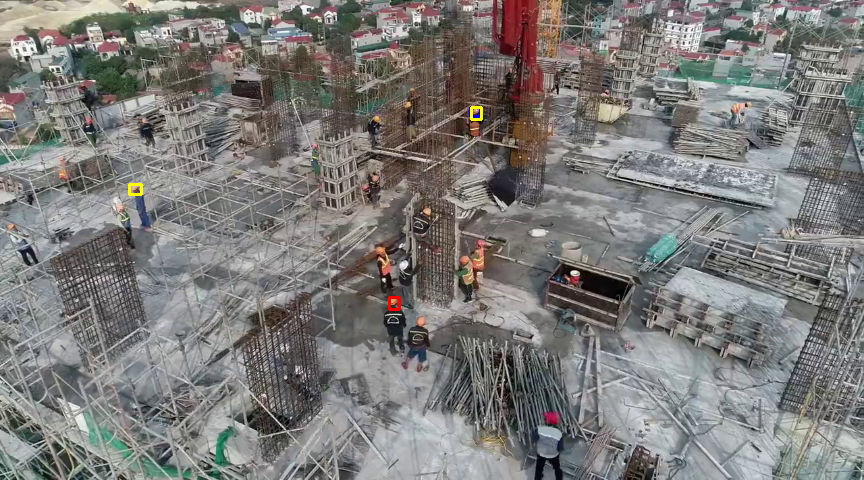

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker

trackers = []
for class_no in range(len(classes)):
    trackers.append(BYTETracker()) # Default tracker frame rate is 30

# loop over frames from the video file stream
vs =  cv.VideoCapture(Test_file)
frame_no = 0
while True:
    # read the next frame from the file   
    (grabbed, FRAME) = vs.read()
    # if the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break
    # if the frame dimensions are empty, grab them(Just get the dimensions of any one frame)
    if W is None or H is None:
        (H, W) = FRAME.shape[:2]

    #Reshape frame to make sure that W, H are divisible by 32. Then new W, H will be used throughout
    FRAME = cv.resize(FRAME, (Width, Height))

    frame_no = frame_no + 1

    #if((frame_no % 200 == 0) && ((frame > 800) && (frame<2400)) || ((frame > 800) && (frame<2400)) || ((frame > 800) && (frame<2400))):
    if((frame_no % stride) != 0):
        continue


    start = time.time()
    # create input blob 
    blob = cv.dnn.blobFromImage(FRAME, scale, (Width, Height), (0,0,0), True, crop=False)

    # set input blob for the network
    net.setInput(blob)

    # forward pass
    outs = net.forward(get_output_layers(net))
    OUTS = np.concatenate(outs)
    end = time.time()


    Class_classified = np.argmax(OUTS[:,5:], axis=1)
    # For each class do the following
    for class_no in range(len(classes)):
        dets = OUTS[:, :5]
        #dets = np.concatenate([dets, OUTS[:, (5+class_no):(6+class_no)]], axis=1)
        dets = dets[Class_classified==class_no, :]
        online_targets = trackers[class_no].update(dets, (Height, Width), (Height, Width))
        print(online_targets)
        # Boxes by BYTETracker
        for t in online_targets:
            w = (t.tlwh[0] + t.tlwh[2])*Width
            h = (t.tlwh[1] + t.tlwh[3])*Height
            x = t.tlwh[0]*Width - w/2
            y = t.tlwh[1]*Height - h/2
            draw_bounding_box(FRAME, class_no, 0, round(x), round(y), round(x+w), round(y+h))
   

    #clear_output(wait = True)
    print(frame_no, (end-start))#"[INFO] estimated total time to finish: {:.4f}".format(elap * (1500-frame_no)))

    # Apply non-max suppression
    #indices = cv.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv.VideoWriter_fourcc(*"MJPG")
        #writer = cv.VideoWriter(Detected_file, fourcc, 30, (FRAME.shape[1], FRAME.shape[0]), True)
		# some information on processing single frame
    if total > 0:
        elap = (end - start)
#        print("[INFO] single frame took {:.4f} seconds".format(elap))
    # write the output frame to disk
    cv2_imshow(FRAME)
    sys.exit()
    for i in range(stride):
        writer.write(FRAME)
        